In [1]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 27.7 MB/s eta 0:00:00


In [8]:
import pandas as pd

# 파일 다시 로드
try:
    df_temp = pd.read_json('KoCoSa_train.json')
except:
    df_temp = pd.read_json('KoCoSa_train.json', lines=True)

# 컬럼 이름 출력
print("📋 실제 데이터 컬럼 목록:", df_temp.columns.tolist())

# 데이터 샘플 출력 (첫 번째 행)
print("\n🔍 첫 번째 데이터 샘플:")
print(df_temp.iloc[0])

📋 실제 데이터 컬럼 목록: ['Context', 'Response', 'Sarcasm_Label', 'Sarcasm_Explanation']

🔍 첫 번째 데이터 샘플:
Context                A: 최근에 본 영화 중에 추천할 만한 것이 있나요?\nB: 저는 "터미네이터"를 ...
Response                          A: 아, 그럼 정말로 마지막 장면은 놀라울 정도로 감동적이었겠군요.
Sarcasm_Label                                                Non-Sarcasm
Sarcasm_Explanation                                                     
Name: 0, dtype: object


데이터 로딩 및 라벨 변환 중...
학습 데이터 크기: 10466
테스트 데이터 크기: 1037
라벨 분포 (Train): {1: 6237, 0: 4229}

🚀 Case 1: 전처리 없는 모델 학습 중...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


🚀 Case 2: 전처리 적용 모델 학습 중... (KoNLPy + Bigram)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



📊 결과 비교:
1. 전처리 없음 - Accuracy: 0.6075, F1: 0.7128
2. 전처리 적용 - Accuracy: 0.6567, F1: 0.7439
📈 성능 차이: 4.92%p


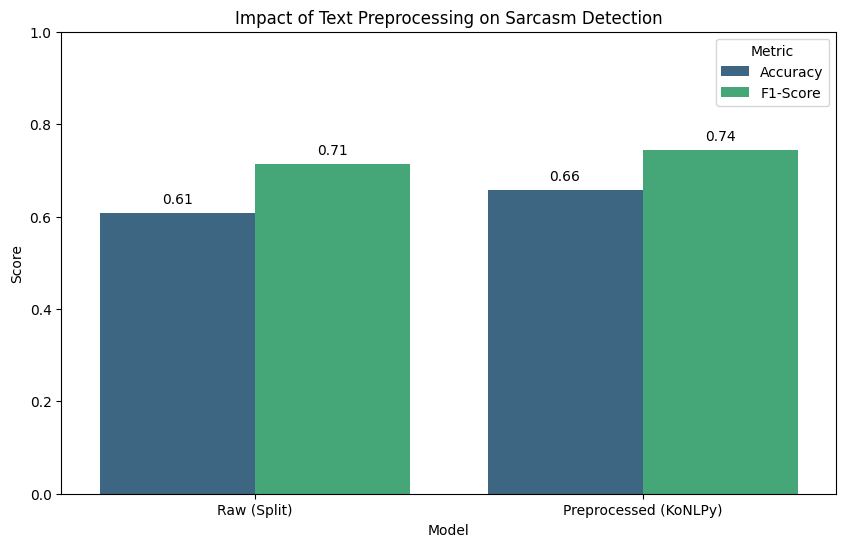

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

# 1. 데이터 로드 및 전처리 (컬럼명 수정 반영)
def load_and_preprocess(file_path):
    try:
        df = pd.read_json(file_path)
    except:
        df = pd.read_json(file_path, lines=True)

    # (1) 텍스트 결합: Context + Response
    # Context가 이미 문자열이므로 리스트 변환 불필요
    df['full_text'] = df['Context'] + " " + df['Response']

    # (2) 라벨 인코딩: "Sarcasm" -> 1, "Non-Sarcasm" -> 0
    # 데이터에 따라 "Sarcasm" 대소문자가 다를 수 있어 처리
    df['label'] = df['Sarcasm_Label'].apply(lambda x: 1 if "Non" not in str(x) else 0)

    return df

print("데이터 로딩 및 라벨 변환 중...")
train_df = load_and_preprocess('KoCoSa_train.json')
test_df = load_and_preprocess('KoCoSa_test.json')

print(f"학습 데이터 크기: {len(train_df)}")
print(f"테스트 데이터 크기: {len(test_df)}")
print(f"라벨 분포 (Train): {train_df['label'].value_counts().to_dict()}") # 0과 1 비율 확인


# 2. 비교 실험 설정

# [Case 1] 전처리 없는 단순 띄어쓰기 토크나이저
def tokenizer_raw(text):
    return text.split()  # 공백 기준 분리

# [Case 2] 전처리 적용 (KoNLPy 형태소 분석 + 불용어 제거)
okt = Okt()
stop_words = ['은', '는', '이', '가', '을', '를', '의', '에', '도', '나', '들', '하다', '있다', '되다']

def tokenizer_preprocessed(text):
    # 어간 추출(stem=True)로 '했어', '했다' -> '하다'로 통일
    morphs = okt.morphs(text, stem=True)
    return [word for word in morphs if word not in stop_words]

# 파이프라인 생성 함수
def create_pipeline(tokenizer_func, ngram_range=(1, 1)):
    return Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=tokenizer_func, ngram_range=ngram_range, min_df=2)),
        ('clf', LogisticRegression(solver='liblinear', random_state=42))
    ])


# 3. 모델 학습 및 평가

# (A) Raw Model (전처리 X)
print("\n🚀 Case 1: 전처리 없는 모델 학습 중...")
pipe_raw = create_pipeline(tokenizer_raw)
pipe_raw.fit(train_df['full_text'], train_df['label'])
pred_raw = pipe_raw.predict(test_df['full_text'])
acc_raw = accuracy_score(test_df['label'], pred_raw)
f1_raw = f1_score(test_df['label'], pred_raw)

# (B) Preprocessed Model (전처리 O + Bigram)
print("🚀 Case 2: 전처리 적용 모델 학습 중... (KoNLPy + Bigram)")
pipe_prep = create_pipeline(tokenizer_preprocessed, ngram_range=(1, 2))
pipe_prep.fit(train_df['full_text'], train_df['label'])
pred_prep = pipe_prep.predict(test_df['full_text'])
acc_prep = accuracy_score(test_df['label'], pred_prep)
f1_prep = f1_score(test_df['label'], pred_prep)


# 4. 결과 시각화
results = pd.DataFrame({
    'Model': ['Raw (Split)', 'Raw (Split)', 'Preprocessed (KoNLPy)', 'Preprocessed (KoNLPy)'],
    'Metric': ['Accuracy', 'F1-Score', 'Accuracy', 'F1-Score'],
    'Score': [acc_raw, f1_raw, acc_prep, f1_prep]
})

print("\n" + "="*40)
print(f"📊 결과 비교:")
print(f"1. 전처리 없음 - Accuracy: {acc_raw:.4f}, F1: {f1_raw:.4f}")
print(f"2. 전처리 적용 - Accuracy: {acc_prep:.4f}, F1: {f1_prep:.4f}")
print(f"📈 성능 차이: {(acc_prep - acc_raw)*100:.2f}%p")
print("="*40)

# 그래프 그리기
plt.figure(figsize=(10, 6))
# 한글 폰트 깨짐 방지를 위해 영문 라벨 사용
sns.barplot(data=results, x='Model', y='Score', hue='Metric', palette='viridis')
plt.title('Impact of Text Preprocessing on Sarcasm Detection')
plt.ylim(0, 1.0)

# 막대 위에 수치 표시
for p in plt.gca().patches:
    if p.get_height() > 0: # 0보다 클 때만 표시
        plt.gca().annotate(f'{p.get_height():.2f}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

In [ ]:
!pip install transformers datasets accelerate scikit-learn

In [13]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# ---------------------------------------------------------
# 2. 데이터 로드 및 전처리 클래스 정의
# ---------------------------------------------------------

# KoCoSa 데이터 로드 함수 (이전 단계와 동일)
def load_kocosa(file_path):
    try:
        df = pd.read_json(file_path)
    except:
        df = pd.read_json(file_path, lines=True)

    # 텍스트 결합 (Context + Response)
    df['full_text'] = df['Context'] + " [SEP] " + df['Response']

    # 라벨 인코딩 (Non-Sarcasm -> 0, Sarcasm -> 1)
    df['label'] = df['Sarcasm_Label'].apply(lambda x: 0 if "Non" in str(x) else 1)
    return df

# 커스텀 데이터셋 클래스 (PyTorch용)
class KoCoSaDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df['full_text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ---------------------------------------------------------
# 3. 모델 학습 준비
# ---------------------------------------------------------

# 파일 로드 (업로드한 파일명 확인 필요)
print("데이터 로딩 중...")
train_df = load_kocosa('KoCoSa_train.json')
test_df = load_kocosa('KoCoSa_test.json')
# dev_df = load_kocosa('KoCoSa_dev.json') # 필요 시 사용

# 토크나이저 및 모델 로드 (KLUE-BERT 사용)
model_name = "beomi/kcbert-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 데이터셋 생성
train_dataset = KoCoSaDataset(train_df, tokenizer)
test_dataset = KoCoSaDataset(test_df, tokenizer)

# ---------------------------------------------------------
# 4. 학습 설정 (Trainer API 활용)
# ---------------------------------------------------------

# 평가 지표 계산 함수
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='binary')
    return {'accuracy': acc, 'f1': f1}

# 학습 파라미터 설정
training_args = TrainingArguments(
    output_dir='./results',          # 결과 저장 경로
    num_train_epochs=3,              # 학습 에폭 수
    per_device_train_batch_size=16,  # 배치 사이즈
    per_device_eval_batch_size=64,
    warmup_steps=500,                # 웜업 스텝
    weight_decay=0.01,               # 가중치 감쇠
    logging_dir='./logs',            # 로그 저장 경로
    logging_steps=100,

    # [수정된 부분] evaluation_strategy -> eval_strategy
    eval_strategy="epoch",           # 매 에폭마다 평가

    save_strategy="epoch",           # 매 에폭마다 모델 저장
    load_best_model_at_end=True,     # 가장 성능 좋은 모델 불러오기
)

# 트레이너 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# ---------------------------------------------------------
# 5. 학습 실행 및 결과 확인
# ---------------------------------------------------------

print("\n🚀 BERT 모델 학습 시작...")
trainer.train()

print("\n📊 최종 테스트 결과 평가:")
metrics = trainer.evaluate()
print(metrics)

# ---------------------------------------------------------
# 6. 실제 예측 함수 (데모용)
# ---------------------------------------------------------
def predict_sarcasm(context, response):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # input_text를 response만 사용하도록 변경
    input_text = response

    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
        score = probs[0][1].item() # Sarcasm일 확률

    label = "풍자(Sarcasm) ⭕️" if pred == 1 else "일반(Non-Sarcasm) ❌"
    print(f"\n상황: {context}")
    print(f"발화: {response}")
    print(f"결과: {label} (확률: {score:.2f})")

# 테스트
predict_sarcasm("차가 너무 막혀서 1시간이나 늦었어", "와 너는 정말 시간 약속을 칼같이 지키는구나")

데이터 로딩 중...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 BERT 모델 학습 시작...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.572100,0.536463,0.729990,0.762712
2,0.510400,0.483827,0.756991,0.798722
3,0.330100,0.617066,0.739634,0.788069



📊 최종 테스트 결과 평가:


{'eval_loss': 0.4838266670703888, 'eval_accuracy': 0.7569913211186113, 'eval_f1': 0.7987220447284346, 'eval_runtime': 22.4688, 'eval_samples_per_second': 46.153, 'eval_steps_per_second': 0.757, 'epoch': 3.0}

상황: 차가 너무 막혀서 1시간이나 늦었어
발화: 와 너는 정말 시간 약속을 칼같이 지키는구나
결과: 풍자(Sarcasm) ⭕️ (확률: 0.70)


In [ ]:
# 1. 라이브러리 설치
!pip install nltk googletrans==4.0.0-rc1

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from googletrans import Translator
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import time

# VADER 사전 다운로드
nltk.download('vader_lexicon')

# 2. VADER 분석기 초기화
analyzer = SentimentIntensityAnalyzer()
translator = Translator()

# 3. 예측 함수 정의
def predict_vader_sarcasm(text):
    try:
        # (1) 한국어 -> 영어 번역
        translated = translator.translate(text, src='ko', dest='en').text

        # (2) 감성 점수 계산 (Compound: -1 ~ +1)
        score = analyzer.polarity_scores(translated)['compound']

        # (3) Sarcasm 판별 로직 (가설)
        # 가설 A: 부정적이면 Sarcasm일 것이다? (일반적인 악플 탐지)
        # 가설 B: 긍정적인 단어인데 문맥이 이상하면 Sarcasm? (VADER로는 불가능)

        # 단순 가정: 매우 부정적인 뉘앙스(악플성 비꼼)를 잡는다고 가정
        # compound 점수가 음수이면 Sarcasm(1), 양수이면 Non-Sarcasm(0)
        # (이 로직은 "반어법"을 못 잡는 한계가 명확함)
        if score <= -0.05:
            return 1 # Sarcasm
        else:
            return 0 # Non-Sarcasm

    except Exception as e:
        return 0 # 번역 에러 시 0 처리

# 4. 테스트 (소량 데이터로 진행)
# test_df는 이전 단계에서 로드한 데이터프레임
print("VADER 실험 시작 (상위 20개만 테스트)...")

# 시간이 오래 걸리므로 20개만 샘플링
sample_df = test_df.head(20).copy()

# 예측 수행
sample_df['vader_pred'] = sample_df['Response'].apply(predict_vader_sarcasm)

# 5. 결과 평가
print("\n--- VADER 성능 평가 (샘플) ---")
print(classification_report(sample_df['label'], sample_df['vader_pred'], target_names=['Non-Sarcasm', 'Sarcasm']))

# 실제 실패 사례 확인 (이 부분이 중요!)
print("\n--- VADER가 틀린 사례 분석 ---")
for idx, row in sample_df.iterrows():
    if row['label'] != row['vader_pred']:
        print(f"문장: {row['Response']}")
        print(f"정답: {row['label']}, VADER 예측: {row['vader_pred']}")
        print("-" * 30)